1. **Importations & Configuration**

In [76]:
# Analyse des Donn√©es de Qualit√© de l'Air en Temps R√©el
# Notebook pour collecter, analyser et visualiser les donn√©es d'APIs

import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from typing import Dict, Optional, List
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Configuration des APIs
AQICN_API_KEY = "d6dc128a0628a9274ab78ee69152ca8d572dc7cc"
OPENWEATHER_API_KEY = "dd2d8c2c92a3ebe773b453884a7f08c0"

# Villes fran√ßaises avec coordonn√©es
FRENCH_CITIES = [
    ("Paris", 48.8566, 2.3522),
    ("Marseille", 43.2965, 5.3698),
    ("Lyon", 45.7640, 4.8357),
    ("Toulouse", 43.6045, 1.4440),
    ("Nice", 43.7102, 7.2620),
    ("Nantes", 47.2184, -1.5536),
    ("Montpellier", 43.6109, 3.8772),
    ("Strasbourg", 48.5734, 7.7521),
    ("Bordeaux", 44.8378, -0.5792),
    ("Lille", 50.6292, 3.0573),
    ("Rennes", 48.1173, -1.6778),
    ("Reims", 49.2583, 4.0317),
    ("Saint-√âtienne", 45.4397, 4.3872),
    ("Le Havre", 49.4944, 0.1079),
    ("Toulon", 43.1242, 5.9280),
    ("Grenoble", 45.1885, 5.7245),
    ("Dijon", 47.3220, 5.0415),
    ("Angers", 47.4784, -0.5632),
    ("N√Æmes", 43.8367, 4.3601),
    ("Villeurbanne", 45.7719, 4.8902)
]

2. **Collecte des Donn√©es AQICN**

In [3]:
class AQICNCollector:
    BASE_URL = "https://api.waqi.info/feed/{city}/?token={key}"
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        
    def fetch_full_data(self, city: str) -> Optional[Dict]:
        url = self.BASE_URL.format(city=city, key=self.api_key)
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if data['status'] != 'ok':
                print(f"‚ùå Erreur API pour {city}: {data.get('message', 'Status not OK')}")
                return None
                
            return self._transform_data(data['data'], city)
            
        except Exception as e:
            print(f"‚ùå Erreur r√©seau pour {city}: {str(e)}")
            return None
            
    def _transform_data(self, raw_data: Dict, city: str) -> Dict:
        """Extraction compl√®te de tous les champs disponibles"""
        iaqi = raw_data.get('iaqi', {})
        time_data = raw_data.get('time', {})
        
        return {
            'source': 'aqicn',
            'city': city,
            'timestamp': datetime.now().isoformat(),
            'data_timestamp': f"{time_data.get('s')}T{time_data.get('tz')}",
            'aqi': raw_data.get('aqi'),
            'dominant_pollutant': raw_data.get('dominentpol'),
            'station': {
                'name': raw_data.get('city', {}).get('name'),
                'url': raw_data.get('city', {}).get('url'),
                'geo': raw_data.get('city', {}).get('geo')
            },
            'pollutants': {
                p: v.get('v') for p, v in iaqi.items() if isinstance(v, dict)
            },
            'attributions': raw_data.get('attributions', []),
            'forecast': raw_data.get('forecast', {})
        }

2. **Collecte des Donn√©es OpenWeatherCollector**

In [7]:
class OpenWeatherCollector:
    AIR_POLLUTION_URL = "http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={key}"
    WEATHER_URL = "https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={key}&units=metric&lang=fr"
    
    def __init__(self, api_key: str):
        self.api_key = api_key
        
    def fetch_full_data(self, city: str, lat: float, lon: float) -> Optional[Dict]:
        try:
            # Donn√©es pollution
            pollution = self._fetch_air_pollution(lat, lon)
            # Donn√©es m√©t√©o standard
            weather = self._fetch_weather(lat, lon)
            
            return {
                'source': 'openweather',
                'city': city,
                'timestamp': datetime.now().isoformat(),
                'coordinates': {'lat': lat, 'lon': lon},
                'air_pollution': pollution,
                'weather': weather
            }
            
        except Exception as e:
            print(f"‚ùå Erreur OpenWeather pour {city}: {str(e)}")
            return None
            
    def _fetch_air_pollution(self, lat: float, lon: float) -> Dict:
        url = self.AIR_POLLUTION_URL.format(lat=lat, lon=lon, key=self.api_key)
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        return response.json()
        
    def _fetch_weather(self, lat: float, lon: float) -> Dict:
        url = self.WEATHER_URL.format(lat=lat, lon=lon, key=self.api_key)
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        return response.json()


3. **Collecte des donn√©es en temps r√©el**

In [10]:
def collect_all_data():
    """Collecte toutes les donn√©es des APIs"""
    print("üîÑ Collecte des donn√©es en temps r√©el...")
    
    # Initialisation des collecteurs
    aqicn_collector = AQICNCollector(AQICN_API_KEY)
    openweather_collector = OpenWeatherCollector(OPENWEATHER_API_KEY)
    
    aqicn_data = []
    openweather_data = []
    
    for city, lat, lon in FRENCH_CITIES:
        print(f"üìç Collecte pour {city}...")
        
        # Donn√©es AQICN
        aqicn_result = aqicn_collector.fetch_full_data(city)
        if aqicn_result:
            aqicn_data.append(aqicn_result)
            print(f"  AQICN: AQI={aqicn_result.get('aqi', 'N/A')}")
        
        # Donn√©es OpenWeather
        weather_result = openweather_collector.fetch_full_data(city, lat, lon)
        if weather_result:
            openweather_data.append(weather_result)
            temp = weather_result.get('weather', {}).get('main', {}).get('temp', 'N/A')
            print(f"  OpenWeather: Temp={temp}¬∞C")
        
        # Pause pour respecter les limites d'API
        import time
        time.sleep(1)
    
    return aqicn_data, openweather_data

# Collecte des donn√©es
aqicn_raw_data, openweather_raw_data = collect_all_data()

print(f"\nüìä Donn√©es collect√©es:")
print(f"  ‚Ä¢ AQICN: {len(aqicn_raw_data)} villes")
print(f"  ‚Ä¢ OpenWeather: {len(openweather_raw_data)} villes")


üîÑ Collecte des donn√©es en temps r√©el...
üìç Collecte pour Paris...
  AQICN: AQI=62
  OpenWeather: Temp=22.19¬∞C
üìç Collecte pour Marseille...
  AQICN: AQI=58
  OpenWeather: Temp=26.3¬∞C
üìç Collecte pour Lyon...
  AQICN: AQI=7
  OpenWeather: Temp=22.15¬∞C
üìç Collecte pour Toulouse...
  AQICN: AQI=34
  OpenWeather: Temp=24.97¬∞C
üìç Collecte pour Nice...
  AQICN: AQI=83
  OpenWeather: Temp=27.38¬∞C
üìç Collecte pour Nantes...
  AQICN: AQI=32
  OpenWeather: Temp=22.06¬∞C
üìç Collecte pour Montpellier...
  AQICN: AQI=35
  OpenWeather: Temp=26.94¬∞C
üìç Collecte pour Strasbourg...
  AQICN: AQI=20
  OpenWeather: Temp=23.05¬∞C
üìç Collecte pour Bordeaux...
  AQICN: AQI=22
  OpenWeather: Temp=24.21¬∞C
üìç Collecte pour Lille...
  AQICN: AQI=61
  OpenWeather: Temp=23.13¬∞C
üìç Collecte pour Rennes...
  AQICN: AQI=29
  OpenWeather: Temp=21.78¬∞C
üìç Collecte pour Reims...
  AQICN: AQI=38
  OpenWeather: Temp=22¬∞C
üìç Collecte pour Saint-√âtienne...
  AQICN: AQI=10
  OpenWeat

4. **Transformation en DataFrames**

In [12]:
def transform_aqicn_data(raw_data: List[Dict]) -> pd.DataFrame:
    """Transforme les donn√©es AQICN en DataFrame"""
    records = []
    
    for data in raw_data:
        record = {
            'city': data['city'],
            'timestamp': data['timestamp'],
            'aqi': data.get('aqi'),
            'dominant_pollutant': data.get('dominant_pollutant'),
            'station_name': data.get('station', {}).get('name'),
            'station_geo': str(data.get('station', {}).get('geo', [])),
        }
        
        # Ajout des polluants
        pollutants = data.get('pollutants', {})
        for pollutant, value in pollutants.items():
            record[f'pollutant_{pollutant}'] = value
            
        records.append(record)
    
    return pd.DataFrame(records)

def transform_openweather_data(raw_data: List[Dict]) -> pd.DataFrame:
    """Transforme les donn√©es OpenWeather en DataFrame"""
    records = []
    
    for data in raw_data:
        weather = data.get('weather', {})
        pollution = data.get('air_pollution', {})
        
        record = {
            'city': data['city'],
            'timestamp': data['timestamp'],
            'latitude': data['coordinates']['lat'],
            'longitude': data['coordinates']['lon'],
        }
        
        # Donn√©es m√©t√©o
        if 'main' in weather:
            main = weather['main']
            record.update({
                'temperature': main.get('temp'),
                'feels_like': main.get('feels_like'),
                'humidity': main.get('humidity'),
                'pressure': main.get('pressure'),
            })
        
        if 'wind' in weather:
            record['wind_speed'] = weather['wind'].get('speed')
            record['wind_deg'] = weather['wind'].get('deg')
        
        if 'weather' in weather and weather['weather']:
            record['weather_main'] = weather['weather'][0].get('main')
            record['weather_description'] = weather['weather'][0].get('description')
        
        # Donn√©es de pollution
        if 'list' in pollution and pollution['list']:
            aqi_data = pollution['list'][0]
            record['aqi_openweather'] = aqi_data.get('main', {}).get('aqi')
            
            components = aqi_data.get('components', {})
            for component, value in components.items():
                record[f'component_{component}'] = value
        
        records.append(record)
    
    return pd.DataFrame(records)

# Transformation des donn√©es
aqicn_df = transform_aqicn_data(aqicn_raw_data)
openweather_df = transform_openweather_data(openweather_raw_data)

print(f"\nüìã DataFrames cr√©√©s:")
print(f"  ‚Ä¢ AQICN: {aqicn_df.shape[0]} lignes, {aqicn_df.shape[1]} colonnes")
print(f"  ‚Ä¢ OpenWeather: {openweather_df.shape[0]} lignes, {openweather_df.shape[1]} colonnes")


üìã DataFrames cr√©√©s:
  ‚Ä¢ AQICN: 20 lignes, 18 colonnes
  ‚Ä¢ OpenWeather: 20 lignes, 21 colonnes


5. **Aper√ßu des donn√©es**

In [82]:
print("\n" + "="*50)
print("üìä APER√áU DES DONN√âES AQICN")
print("="*50)
if not aqicn_df.empty:
    print(aqicn_df.head())
    print(f"\nColonnes: {list(aqicn_df.columns)}")
    
    # Statistiques AQI
    if 'aqi' in aqicn_df.columns:
        print(f"\nüìà Statistiques AQI:")
        print(aqicn_df['aqi'].describe())

print("\n" + "="*50)
print("üå§Ô∏è APER√áU DES DONN√âES OPENWEATHER")
print("="*50)
if not openweather_df.empty:
    print(openweather_df.head())
    print(f"\nColonnes: {list(openweather_df.columns)}")
    
    # Statistiques m√©t√©o
    numeric_cols = openweather_df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nüìà Statistiques num√©riques:")
        print(openweather_df[numeric_cols].describe())



üìä APER√áU DES DONN√âES AQICN
        city                   timestamp  aqi dominant_pollutant  \
0      Paris  2025-06-16T13:36:26.454218   62               pm25   
1  Marseille  2025-06-16T13:36:29.047975   58               pm10   
2       Lyon  2025-06-16T13:36:31.712410    7               pm10   
3   Toulouse  2025-06-16T13:36:34.174997   34                 o3   
4       Nice  2025-06-16T13:36:36.670373   83               pm25   

                        station_name                station_geo  pollutant_co  \
0                              Paris     [48.856614, 2.3522219]           0.1   
1  Marseille 5 Avenues, PACA, France      [43.305287, 5.394716]           0.1   
2         Lyon Trafic Jaur√®s, France  [45.74972628, 4.84439392]           NaN   
3         Toulouse Berthelot, France  [43.5873309, 1.444026232]           NaN   
4           Nice Arson, PACA, France      [43.702075, 7.286256]           NaN   

   pollutant_h  pollutant_no2  pollutant_o3  pollutant_p  pollutant_pm

6. **Analyse de la qualit√© des donn√©es**

In [64]:
class DataQualityAnalyzer:
    @staticmethod
    def analyze_completeness(df, source_name):
        """Analyse du taux de compl√©tude"""
        print(f"\nüîç Analyse de compl√©tude - {source_name}")
        print("-" * 40)
        
        total_cells = df.size
        missing_cells = df.isnull().sum().sum()
        completeness = (1 - missing_cells / total_cells) * 100
        
        print(f"Taux de compl√©tude global: {completeness:.2f}%")
        
        # Par colonne
        missing_by_col = df.isnull().sum()
        missing_pct = (missing_by_col / len(df)) * 100
        
        missing_summary = pd.DataFrame({
            'Valeurs manquantes': missing_by_col,
            'Pourcentage': missing_pct
        }).sort_values('Pourcentage', ascending=False)
        
        if missing_summary['Valeurs manquantes'].sum() > 0:
            print("\nValeurs manquantes par colonne:")
            print(missing_summary[missing_summary['Valeurs manquantes'] > 0])
        else:
            print("‚úÖ Aucune valeur manquante d√©tect√©e")
        
        return missing_summary
    
    @staticmethod
    def analyze_data_ranges(df, source_name):
        """Analyse des plages de valeurs"""
        print(f"\nüìä Analyse des plages - {source_name}")
        print("-" * 40)
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            values = df[col].dropna()
            if len(values) > 0:
                print(f"{col}: {values.min():.2f} ‚Üí {values.max():.2f} (moy: {values.mean():.2f})")

# Analyse de qualit√©
analyzer = DataQualityAnalyzer()

if not aqicn_df.empty:
    analyzer.analyze_completeness(aqicn_df, "AQICN")
    analyzer.analyze_data_ranges(aqicn_df, "AQICN")

if not openweather_df.empty:
    analyzer.analyze_completeness(openweather_df, "OpenWeather")
    analyzer.analyze_data_ranges(openweather_df, "OpenWeather")



üîç Analyse de compl√©tude - AQICN
----------------------------------------
Taux de compl√©tude global: 84.17%

Valeurs manquantes par colonne:
                Valeurs manquantes  Pourcentage
pollutant_co                    17         85.0
pollutant_so2                   14         70.0
pollutant_wg                     8         40.0
pollutant_dew                    7         35.0
pollutant_pm25                   5         25.0
pollutant_o3                     4         20.0
pollutant_no2                    1          5.0
pollutant_pm10                   1          5.0

üìä Analyse des plages - AQICN
----------------------------------------
aqi: 7.00 ‚Üí 83.00 (moy: 34.00)
pollutant_co: 0.10 ‚Üí 0.10 (moy: 0.10)
pollutant_h: 31.00 ‚Üí 92.00 (moy: 60.44)
pollutant_no2: 1.10 ‚Üí 20.60 (moy: 8.40)
pollutant_o3: 11.00 ‚Üí 35.30 (moy: 26.59)
pollutant_p: 1010.80 ‚Üí 1045.20 (moy: 1024.72)
pollutant_pm10: 7.00 ‚Üí 63.00 (moy: 22.26)
pollutant_pm25: 23.00 ‚Üí 83.00 (moy: 48.00)
pollutant_s

7. **Visualisations**

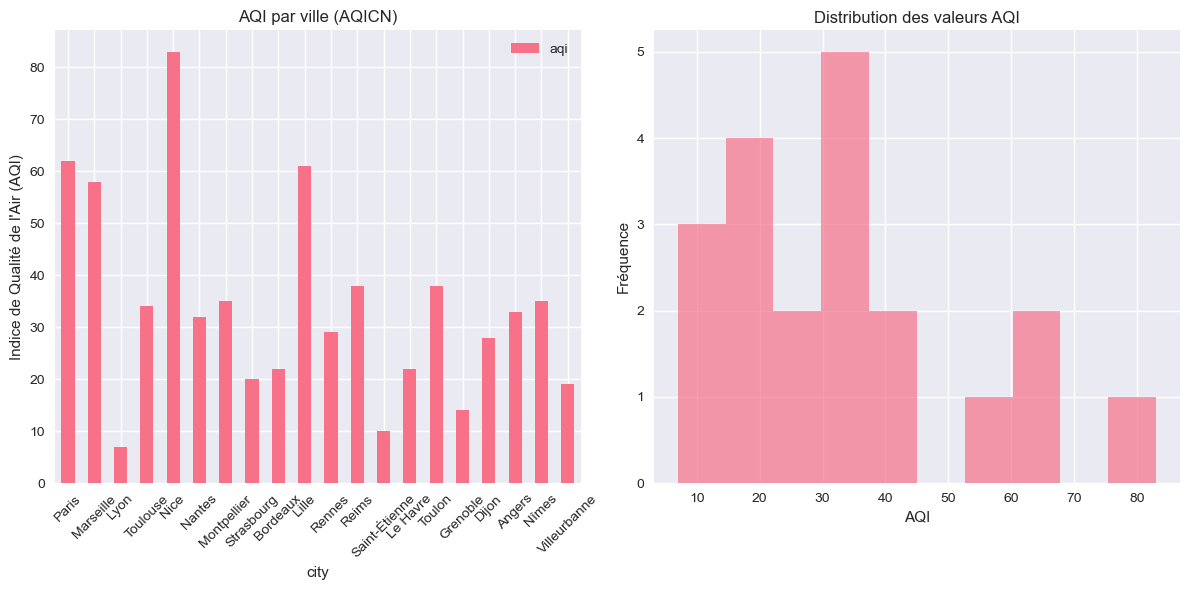

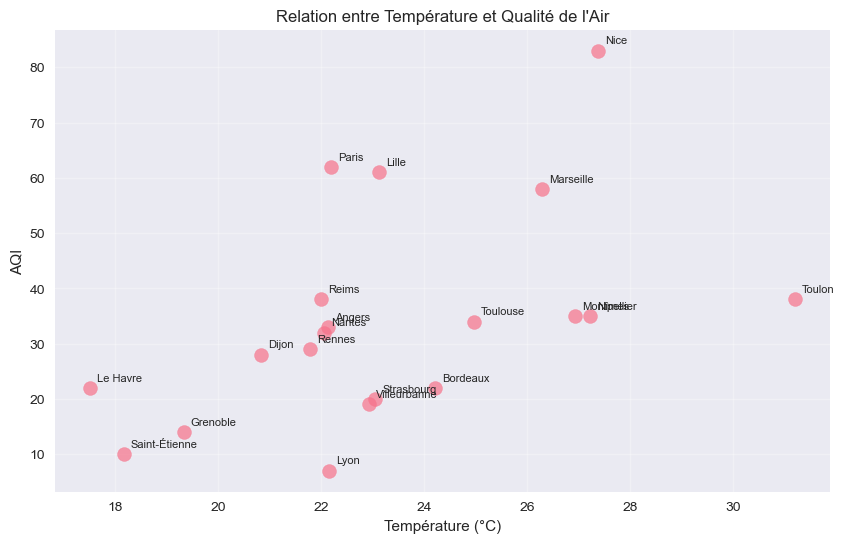

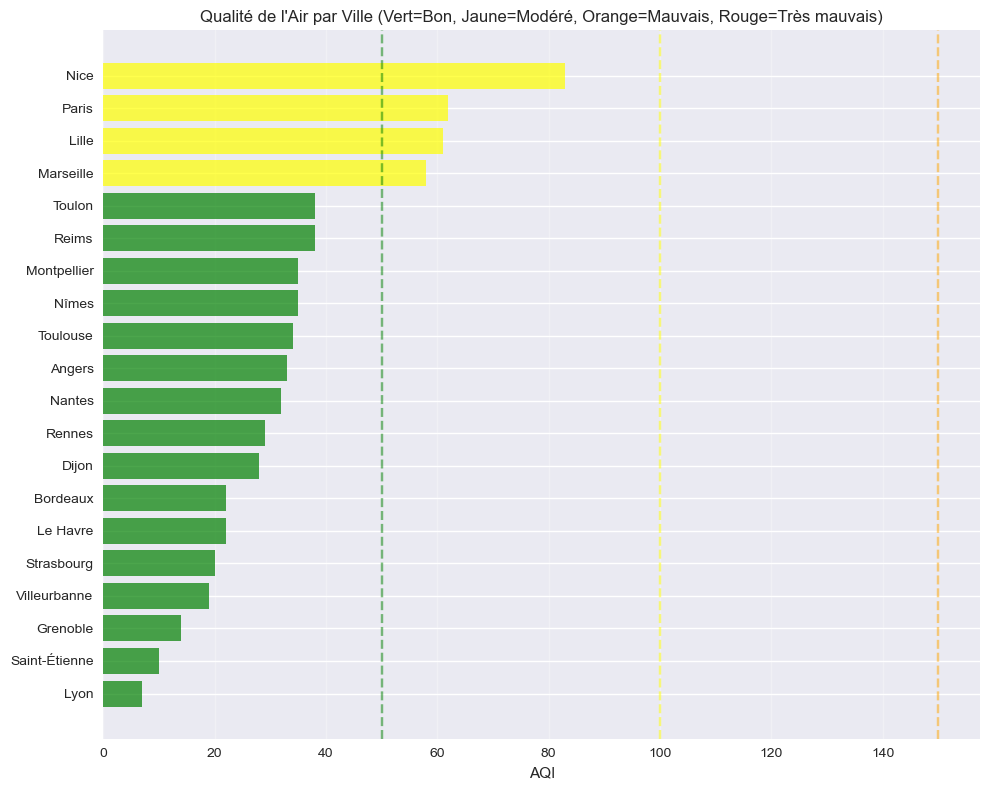

In [84]:
# Graphique AQI par ville (AQICN)
if not aqicn_df.empty and 'aqi' in aqicn_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Supprimer les valeurs nulles
    aqi_data = aqicn_df.dropna(subset=['aqi'])
    
    if not aqi_data.empty:
        # Graphique en barres
        plt.subplot(1, 2, 1)
        aqi_data.plot(x='city', y='aqi', kind='bar', ax=plt.gca())
        plt.title('AQI par ville (AQICN)')
        plt.xticks(rotation=45)
        plt.ylabel('Indice de Qualit√© de l\'Air (AQI)')
        
        # Histogramme
        plt.subplot(1, 2, 2)
        aqi_data['aqi'].hist(bins=10, alpha=0.7)
        plt.title('Distribution des valeurs AQI')
        plt.xlabel('AQI')
        plt.ylabel('Fr√©quence')
        
        plt.tight_layout()
        plt.show()
# Graphique temp√©rature vs AQI
if not openweather_df.empty and not aqicn_df.empty:
    # Fusion des donn√©es par ville
    merged_df = pd.merge(aqicn_df[['city', 'aqi']], 
                        openweather_df[['city', 'temperature']], 
                        on='city', how='inner')
    
    if not merged_df.empty and len(merged_df) > 1:
        plt.figure(figsize=(10, 6))
        plt.scatter(merged_df['temperature'], merged_df['aqi'], alpha=0.7, s=100)
        
        # Ajout des noms de villes
        for i, row in merged_df.iterrows():
            plt.annotate(row['city'], (row['temperature'], row['aqi']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.xlabel('Temp√©rature (¬∞C)')
        plt.ylabel('AQI')
        plt.title('Relation entre Temp√©rature et Qualit√© de l\'Air')
        plt.grid(True, alpha=0.3)
        plt.show()
# Carte de la qualit√© de l'air
if not aqicn_df.empty and 'aqi' in aqicn_df.columns:
    plt.figure(figsize=(10, 8))
    
    # Cr√©er un graphique de qualit√© par ville
    cities_aqi = aqicn_df.dropna(subset=['aqi']).sort_values('aqi', ascending=True)
    
    colors = ['green' if x <= 50 else 'yellow' if x <= 100 else 'orange' if x <= 150 else 'red' 
              for x in cities_aqi['aqi']]
    
    plt.barh(cities_aqi['city'], cities_aqi['aqi'], color=colors, alpha=0.7)
    plt.xlabel('AQI')
    plt.title('Qualit√© de l\'Air par Ville (Vert=Bon, Jaune=Mod√©r√©, Orange=Mauvais, Rouge=Tr√®s mauvais)')
    plt.grid(axis='x', alpha=0.3)
    
    # L√©gende des seuils AQI
    plt.axvline(x=50, color='green', linestyle='--', alpha=0.5)
    plt.axvline(x=100, color='yellow', linestyle='--', alpha=0.5)
    plt.axvline(x=150, color='orange', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()